In [207]:
from tinytag import TinyTag
import librosa
import os
import re
import numpy as np
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import random
import torch.optim as optim
import matplotlib.pyplot as plt


In [208]:
class RekordboxAudioDataset(Dataset):
    def __init__(self, audio_dir, transform=None, target_length=1292):
        super().__init__()
        self.audio_dir = audio_dir
        self.transform = transform
        self.target_length = target_length
        self.audio_files = []
        self.true_tempos = []
        self.features = []
        
        self._load_audio_files()
        
    def _pad_or_truncate_features(self, features):
        if features.shape[1] < self.target_length:
            padded = np.zeros((features.shape[0], self.target_length))
            padded[:, :features.shape[1]] = features
            return padded
        return features[:, :self.target_length]
        
    def __len__(self):
        return len(self.audio_files)
    
    def normalize_tempo(self, librosa_tempo, true_tempo):
        while librosa_tempo < 78:
            librosa_tempo *= 2
        while librosa_tempo > 155:
            librosa_tempo /= 2
            
        if librosa_tempo * 2 <= 155:
            if abs(librosa_tempo * 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo *= 2
        if librosa_tempo / 2 >= 78:
            if abs(librosa_tempo / 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo /= 2
                
        return librosa_tempo
    
    def _extract_features(self, y, sr, true_tempo):
        try:
            # Use librosa to estimate tempo
            onset_env = librosa.onset.onset_strength(y=y, sr=sr)
            tempo_librosa, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
            
            # Normalize the estimated tempo
            tempo_librosa = self.normalize_tempo(tempo_librosa, true_tempo)
            
            # Normalize librosa estimated tempo to [0,1]
            tempo_librosa_norm = (tempo_librosa - 78) / 77
            
            # Compute MFCCs
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfccs = librosa.util.fix_length(mfccs, size=self.target_length)
            
            # Compute spectral centroid
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_centroid = librosa.util.fix_length(spectral_centroid, size=self.target_length)
            
            # Stack features together
            tempo_feature = np.full((1, self.target_length), tempo_librosa_norm)
            features = np.vstack([tempo_feature, mfccs, spectral_centroid])
            
            return features
        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return np.zeros((15, self.target_length))
    
    def _load_audio_files(self):
        tempo_pattern = re.compile(r'^(\d+\.?\d*)\s+(.+)$')
        all_audio_files = [f for f in os.listdir(self.audio_dir) 
                        if f.endswith(('.mp3', '.wav', '.aiff', '.m4a'))]
        
        for filename in all_audio_files:
            match = tempo_pattern.match(filename)
            if match:
                try:
                    true_tempo = float(match.group(1))
                    audio_path = os.path.join(self.audio_dir, filename)
                    
                    tag = TinyTag.get(audio_path)
                    offset = tag.duration / 3 if tag.duration else 0
                    y, sr = librosa.load(audio_path, offset=offset, duration=30)
                    
                    features = self._extract_features(y, sr, true_tempo)
                    features = self._pad_or_truncate_features(features)
                    
                    self.audio_files.append(filename)
                    self.true_tempos.append(true_tempo)
                    self.features.append(features)
                    
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
                    continue
            else:
                continue  # If filename doesn't match the pattern, skip it
    
    def __getitem__(self, idx):
        true_tempo = self.true_tempos[idx]
        features = self.features[idx]
        
        if self.transform:
            features = self.transform(features)
        
        features = torch.FloatTensor(features)
        # Normalize the true tempo for the target
        true_tempo_norm = (true_tempo - 78) / 77
        target = torch.tensor([true_tempo_norm], dtype=torch.float32)
        
        return features, target

In [209]:
class AugmentedRekordboxDataset(Dataset):
    def __init__(self, base_dataset, augmentations_per_sample=4):
        self.base_dataset = base_dataset
        self.augmentations_per_sample = augmentations_per_sample
        self.feature_length = base_dataset.target_length
        self.feature_shape = (15, self.feature_length)

    def __len__(self):
        return len(self.base_dataset) * self.augmentations_per_sample

    def __getitem__(self, idx):
        original_idx = idx // self.augmentations_per_sample
        features, target = self.base_dataset[original_idx]
        original_tempo_norm = features[0, 0].item()  # Get the original tempo feature

        if idx % self.augmentations_per_sample == 0:
            return features, target

        features_np = features.numpy()
        aug_type = idx % self.augmentations_per_sample

        if aug_type == 1:
            features_np, new_tempo_norm, stretch_factor = self._time_stretch(features_np, original_tempo_norm)
            
            # Adjust the target tempo
            # Convert normalized target back to BPM
            target_bpm = target.item() * 77 + 78
            # Adjust tempo BPM according to stretch factor
            new_target_bpm = target_bpm / stretch_factor
            # Normalize the adjusted BPM back to [0, 1]
            new_target_norm = (new_target_bpm - 78) / 77
            target = torch.tensor([new_target_norm], dtype=torch.float32)

        elif aug_type == 2:
            features_np = self._mask_augment(features_np)

        elif aug_type == 3:
            features_np = self._add_noise(features_np)

        return torch.FloatTensor(features_np), target

    def _time_stretch(self, features, original_tempo_norm):
        stretch_factor = np.random.uniform(0.95, 1.05)
        dynamic_features = features[1:]  # Exclude tempo feature

        # Convert original tempo feature back to BPM
        tempo_bpm = original_tempo_norm * 77 + 78
        # Adjust tempo BPM according to stretch factor
        new_tempo_bpm = tempo_bpm / stretch_factor
        # Normalize the adjusted BPM back to [0, 1]
        new_tempo_norm = (new_tempo_bpm - 78) / 77
        features[0] = new_tempo_norm

        time_axis = self.feature_length
        stretched_length = int(time_axis * stretch_factor)

        stretched = np.zeros((features.shape[0], time_axis))
        stretched[0] = features[0]  # Updated tempo feature

        indices = np.linspace(0, time_axis - 1, stretched_length)
        for i in range(dynamic_features.shape[0]):
            # Time-stretch dynamic features
            temp = np.interp(indices, np.arange(time_axis), dynamic_features[i])
            stretched[i + 1] = np.interp(np.arange(time_axis), np.arange(stretched_length), temp)

        return stretched, new_tempo_norm, stretch_factor

    def _mask_augment(self, features):
        features = features.copy()
        mask_size = random.randint(32, min(128, self.feature_length))
        mask_start = random.randint(0, self.feature_length - mask_size)
        features[1:, mask_start:mask_start + mask_size] = 0  # Mask dynamic features
        return features

    def _add_noise(self, features):
        noise = np.random.normal(0, 0.01, (features.shape[0], self.feature_length))
        noise[0] = 0  # Don't add noise to tempo feature
        return features + noise

In [210]:
# Initialize datasets
audio_dir = "./TellerNet/data/beatbank_test_audios"
base_dataset = RekordboxAudioDataset(audio_dir, target_length=1292)
aug_dataset = AugmentedRekordboxDataset(base_dataset)

# Verify shapes
if len(base_dataset) > 0:
    base_features, base_target = base_dataset[0]
    print(f"Base shape: {base_features.shape}")
    print(f"Base target: {base_target}")
else:
    print("Base dataset is empty.")

if len(aug_dataset) > 0:
    aug_features, aug_target = aug_dataset[0]
    print(f"Augmented shape: {aug_features.shape}")
    print(f"Augmented target: {aug_target}")
else:
    print("Augmented dataset is empty.")

Base shape: torch.Size([15, 1292])
Base target: tensor([0.2857])
Augmented shape: torch.Size([15, 1292])
Augmented target: tensor([0.2857])


In [211]:
# Dataset parameters
target_length = 1292  # Length to pad or truncate features
batch_size = 64       # Increased batch size for more stable gradients
test_size = 0.2       # Fraction of data to use for validation
random_seed = 24     # Random seed for reproducibility

# Training parameters
num_epochs = 1200       # Number of epochs for training
learning_rate = 0.0005 # Reduced learning rate for optimizer

# Model parameters
input_channels = 15   # Number of feature channels

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seeds for reproducibility
import random
import numpy as np

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

In [228]:
# Define scaling and descaling functions
def scale_tempo(tempo):
    return (tempo - 78) / 77

def descale_tempo(scaled_tempo):
    return scaled_tempo * 77 + 78

# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

# Get indices for splitting
dataset_size = len(aug_dataset)
indices = list(range(dataset_size))
train_indices, val_indices = train_test_split(
    indices, test_size=test_size, random_state=random_seed, shuffle=True
)

# Create samplers
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(aug_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(aug_dataset, batch_size=batch_size, sampler=val_sampler)

# Define the CNN model
class TempoEstimationCNN(nn.Module):
    def __init__(self):
        super(TempoEstimationCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32, momentum=0.1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64, momentum=0.1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128, momentum=0.1)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Calculate the output length after convolution and pooling
        conv_output_length = self._calculate_output_length(target_length)
        self.fc1 = nn.Linear(128 * conv_output_length, 256)
        self.fc2 = nn.Linear(256, 1)  # Output is a single value (scaled tempo)

    def _calculate_output_length(self, input_length):
        # Calculate the length after three pooling layers
        length = input_length
        for _ in range(3):
            length = length // 2  # MaxPool with kernel_size=2 halves the length
        return length

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool2(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool3(nn.functional.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

# Initialize the model, loss function, optimizer, and scheduler
model = TempoEstimationCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


In [229]:
train_losses = []
val_losses = []
train_bpm_errors = []
val_bpm_errors = []
best_val_loss = float('inf')
best_model_state = None
epochs_without_improvement = 0
patience = 20  # Early stopping patience

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_bpm_error = 0.0
    for features, targets in train_loader:
        features = features.to(device).permute(0, 1, 2)  # Ensure features are (batch_size, channels, length)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets.squeeze())
        loss.backward()
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * features.size(0)

        # Compute BPM error
        predicted_tempo = descale_tempo(outputs.detach().cpu())
        true_tempo = descale_tempo(targets.squeeze().cpu())
        bpm_error = torch.abs(predicted_tempo - true_tempo)
        running_bpm_error += bpm_error.sum().item()

    epoch_train_loss = running_loss / len(train_indices)
    epoch_train_bpm_error = running_bpm_error / len(train_indices)
    train_losses.append(epoch_train_loss)
    train_bpm_errors.append(epoch_train_bpm_error)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    running_val_bpm_error = 0.0
    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device).permute(0, 1, 2)  # Ensure features are (batch_size, channels, length)
            targets = targets.to(device)
            outputs = model(features)
            loss = criterion(outputs, targets.squeeze())
            running_val_loss += loss.item() * features.size(0)

            # Compute BPM error
            predicted_tempo = descale_tempo(outputs.cpu())
            true_tempo = descale_tempo(targets.squeeze().cpu())
            bpm_error = torch.abs(predicted_tempo - true_tempo)
            running_val_bpm_error += bpm_error.sum().item()

    epoch_val_loss = running_val_loss / len(val_indices)
    epoch_val_bpm_error = running_val_bpm_error / len(val_indices)
    val_losses.append(epoch_val_loss)
    val_bpm_errors.append(epoch_val_bpm_error)

    # Step the scheduler
    scheduler.step(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Train BPM Error: {epoch_train_bpm_error:.2f}, '
          f'Validation Loss: {epoch_val_loss:.4f}, '
          f'Validation BPM Error: {epoch_val_bpm_error:.2f}')

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# Save the best model to a .pth file
torch.save(best_model_state, 'best_tempo_estimation_model.pth')

print("Best model saved to 'best_tempo_estimation_model.pth'")

Epoch [1/1200], Train Loss: 134.9071, Train BPM Error: 569.12, Validation Loss: 0.3104, Validation BPM Error: 35.49
Epoch [2/1200], Train Loss: 0.2309, Train BPM Error: 30.54, Validation Loss: 0.1436, Validation BPM Error: 22.16
Epoch [3/1200], Train Loss: 0.0968, Train BPM Error: 20.12, Validation Loss: 0.0859, Validation BPM Error: 19.61
Epoch [4/1200], Train Loss: 0.0619, Train BPM Error: 15.07, Validation Loss: 0.0677, Validation BPM Error: 16.47
Epoch [5/1200], Train Loss: 0.0391, Train BPM Error: 11.88, Validation Loss: 0.0504, Validation BPM Error: 13.43
Epoch [6/1200], Train Loss: 0.0304, Train BPM Error: 10.23, Validation Loss: 0.0359, Validation BPM Error: 11.45
Epoch [7/1200], Train Loss: 0.0233, Train BPM Error: 8.67, Validation Loss: 0.0317, Validation BPM Error: 10.46
Epoch [8/1200], Train Loss: 0.0195, Train BPM Error: 7.59, Validation Loss: 0.0363, Validation BPM Error: 10.34
Epoch [9/1200], Train Loss: 0.0228, Train BPM Error: 8.65, Validation Loss: 0.0295, Validation 

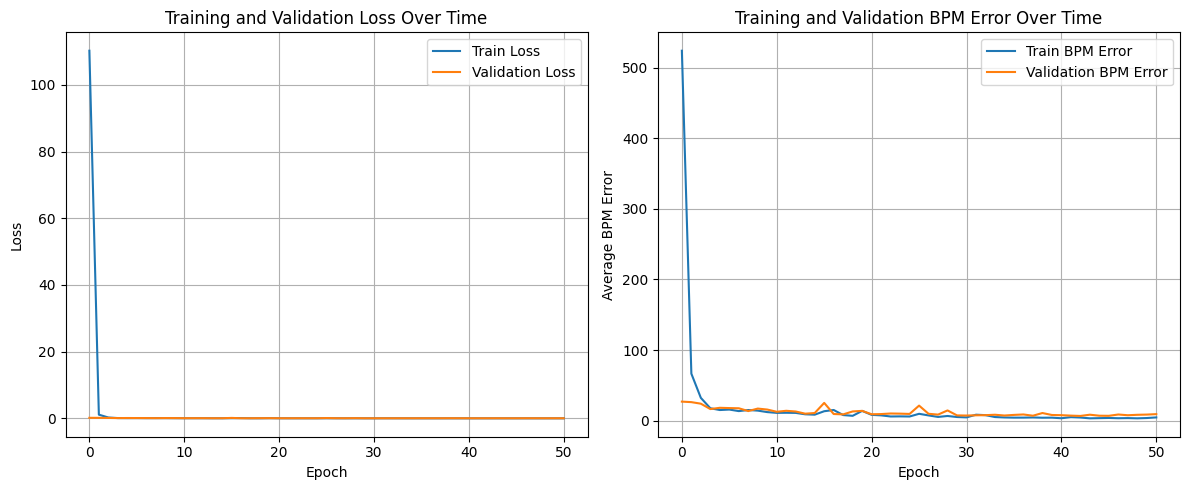

In [195]:
# Cell 8: Plot Training and Validation Losses and BPM Errors

from datetime import datetime


epochs_range = list(range(len(train_losses)))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_bpm_errors, label='Train BPM Error')
plt.plot(epochs_range, val_bpm_errors, label='Validation BPM Error')
plt.xlabel('Epoch')
plt.ylabel('Average BPM Error')
plt.title('Training and Validation BPM Error Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()

# save the plot with datetime
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
plt_dir = os.path.join(os.getcwd(), 'plots')
os.makedirs(plt_dir, exist_ok=True)
plt.savefig(os.path.join(plt_dir, f'training_and_validation_losses_and_bpm_errors_{dt_string}.png'))

plt.show()




In [ ]:
import pandas as pd

# For a single sample
features, target = base_dataset[0]
df = pd.DataFrame(features.numpy().T)  # Transpose to have features as columns

print(df.head())
print(df.describe())


         0           1          2          3          4         5          6   \
0  0.277714 -104.306297  61.304634  48.483185  31.588427 -0.388492   6.545342   
1  0.277714  -15.027751  59.521439  43.895782  36.271381 -4.879782   9.584824   
2  0.277714   17.167740  54.477306  46.773270  35.735451 -1.588144  10.995380   
3  0.277714   -1.801970  48.799179  53.559364  42.342323  2.804133  13.510390   
4  0.277714  -36.541588  50.320770  55.444824  46.882973  6.482944  19.782421   

         7          8         9          10         11         12        13  \
0 -3.304058  17.113129 -0.732365  16.287424  11.112418  18.600895 -3.678835   
1  2.964069  16.491318  0.923566   2.433844   5.701638  12.120886 -2.675537   
2  5.843456  11.218181 -3.426372  -3.058765   4.712077  10.339029 -3.684345   
3  8.387520  11.197969 -2.281571   0.407923   3.096108  10.008212 -2.448124   
4  6.421165   9.696306  3.188858   3.395430   1.021942  10.443627  1.144640   

            14  
0  2967.730957  
1  3

IndexError: tuple index out of range